# Reference


Tensorflow
1. https://www.tensorflow.org/tutorials/images/classification
2. https://www.tensorflow.org/tutorials/load_data/images
3. https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory
4. https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict

Keras (https://keras.io/api/)
1. https://keras.io/examples/vision/image_classification_from_scratch/
2. https://keras.io/guides/preprocessing_layers/

Data_loading >> https://keras.io/api/data_loading/image/
1. image_dataset_from_directory function = Generates a tf.data.Dataset from image files in a directory. (https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory)
2. load_img function = Loads an image into PIL format.
3. img_to_array function = Converts a PIL Image instance to a Numpy array.
4. save_img function = Saves an image stored as a Numpy array to a path or file object.


Keras models accept three types of inputs:
- NumPy arrays
- TensorFlow Dataset objects
- Python generators

# 1.Setup

In [1]:
# List all NVIDIA GPUs as avaialble in this computer (or Colab's session)
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-b750da64-a0fa-50a9-eebd-8fa0b15fe2f9)


In [2]:
import sys
print(f"Python {sys.version}\n")

import numpy as np
print(f"Numpy {np.__version__}\n")

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
print(f"TensorFlow {tf.__version__}")
print(f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}")

# Count the number of GPUs as detected by tensorflow
gpus = tf.config.list_physical_devices('GPU')
print(f"TensorFlow detected {len(gpus)} GPU(s):")
for i,gpu in enumerate(gpus):
  print(f"...GPU No.{i} : Name = {gpu.name}, Type = {gpu.device_type}")

Python 3.7.15 (default, Oct 12 2022, 19:14:55) 
[GCC 7.5.0]

Numpy 1.21.6

TensorFlow 2.9.2
tf.keras.backend.image_data_format() = channels_last
TensorFlow detected 1 GPU(s):
...GPU No.0 : Name = /physical_device:GPU:0, Type = GPU


In [3]:
# Set fixed seeding values for reproducability during experiments
# Skip this cell if random initialization (with varied results) is needed
np.random.seed(1234)
tf.random.set_seed(1234)
# seed = np.random.randint(1000,10000)
seed = 1234

In [4]:
batch_size = 32
image_size = (224, 224) # Default of input_shape is 224x224x3 for MobileNet

# 2.Load data using a Keras utility

In [5]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
# Directory where the data is located. If labels is "inferred", it should contain subdirectories, each containing images for a class.
# Otherwise, the directory structure is ignored.
train_dir = "/content/gdrive/MyDrive/DADS_7202/dataset/train_ds"
test_dir = "/content/gdrive/MyDrive/DADS_7202/dataset/test_ds"

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  labels='inferred',
  label_mode='int', # if label_mode is int, the labels are an int32 tensor of shape (batch_size,)
  class_names=None, # otherwise alphanumerical order is used
  color_mode='rgb',
  batch_size=batch_size,
  image_size=image_size,
  shuffle=True,
  seed=seed,
  validation_split=0.2,
  subset="training",
  interpolation='bilinear',
  follow_links=False,
  crop_to_aspect_ratio=False
  )

Found 354 files belonging to 4 classes.
Using 284 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  labels='inferred',
  label_mode='int', # if label_mode is int, the labels are an int32 tensor of shape (batch_size,)
  class_names=None, # otherwise alphanumerical order is used
  color_mode='rgb',
  batch_size=batch_size,
  image_size=image_size,
  shuffle=True,
  seed=seed,
  validation_split=0.2,
  subset="validation",
  interpolation='bilinear',
  follow_links=False,
  crop_to_aspect_ratio=False
  )

Found 354 files belonging to 4 classes.
Using 70 files for validation.


In [22]:
# Load test_dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  labels='inferred',
  label_mode='int', # if label_mode is int, the labels are an int32 tensor of shape (batch_size,)
  class_names=None, # otherwise alphanumerical order is used
  color_mode='rgb',
  batch_size=batch_size,
  image_size=image_size,
  shuffle=True,
  interpolation='bilinear',
  follow_links=False,
  crop_to_aspect_ratio=False
  )

Found 80 files belonging to 4 classes.


In [9]:
class_names = train_ds.class_names
print(class_names)

['apple', 'huawei', 'oppo', 'samsung']


# 3.Load the pretrained model (only the feature extractor)

In [11]:
img_w,img_h = 224,224 
vgg_extractor = tf.keras.applications.mobilenet.MobileNet(weights = "imagenet", include_top=True,input_shape = (img_w, img_h,3)) 

vgg_extractor.summary()

17225924/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32

In [12]:
# All layer = False
vgg_extractor.trainable = False

# recheck layer.trainable

for i,layer in enumerate(vgg_extractor.layers):  
    print( f"Layer {i}: name = {layer.name} , trainable = {layer.trainable}" )

Layer 0: name = input_1 , trainable = False
Layer 1: name = conv1 , trainable = False
Layer 2: name = conv1_bn , trainable = False
Layer 3: name = conv1_relu , trainable = False
Layer 4: name = conv_dw_1 , trainable = False
Layer 5: name = conv_dw_1_bn , trainable = False
Layer 6: name = conv_dw_1_relu , trainable = False
Layer 7: name = conv_pw_1 , trainable = False
Layer 8: name = conv_pw_1_bn , trainable = False
Layer 9: name = conv_pw_1_relu , trainable = False
Layer 10: name = conv_pad_2 , trainable = False
Layer 11: name = conv_dw_2 , trainable = False
Layer 12: name = conv_dw_2_bn , trainable = False
Layer 13: name = conv_dw_2_relu , trainable = False
Layer 14: name = conv_pw_2 , trainable = False
Layer 15: name = conv_pw_2_bn , trainable = False
Layer 16: name = conv_pw_2_relu , trainable = False
Layer 17: name = conv_dw_3 , trainable = False
Layer 18: name = conv_dw_3_bn , trainable = False
Layer 19: name = conv_dw_3_relu , trainable = False
Layer 20: name = conv_pw_3 , traina

# 4.Compile and train the model

In [13]:
%pwd

'/content'

In [14]:
initial_learning_rate = 0.0001 # Defaults to 0.001

vgg_extractor.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
    loss="sparse_categorical_crossentropy",
    metrics=["acc"]
    )

In [15]:
# %cd "/content/gdrive/MyDrive/DADS_7202/vgg_model/preprocess"

In [16]:
checkpoint_filepath = "bestmodel_epoch{epoch:02d}_valloss{val_loss:.2f}.hdf5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                               save_weights_only=False, 
                                                               monitor='val_acc', 
                                                               mode='max',
                                                               save_best_only=True)

In [17]:
%%time
history = vgg_extractor.fit(train_ds,
                    batch_size = None,
                    epochs=10, verbose=1,
                    validation_data=val_ds,
                    callbacks=[model_checkpoint_callback]
                    )

Epoch 1/10
9/9 [==============================] - 121s 3s/step - loss: 13.4612 - acc: 0.0000e+00 - val_loss: 13.5719 - val_acc: 0.0000e+00
Epoch 2/10
9/9 [==============================] - 2s 91ms/step - loss: 13.4490 - acc: 0.0000e+00 - val_loss: 13.5719 - val_acc: 0.0000e+00
Epoch 3/10
9/9 [==============================] - 2s 81ms/step - loss: 13.4475 - acc: 0.0000e+00 - val_loss: 13.5719 - val_acc: 0.0000e+00
Epoch 4/10
9/9 [==============================] - 2s 80ms/step - loss: 13.4475 - acc: 0.0000e+00 - val_loss: 13.5719 - val_acc: 0.0000e+00
Epoch 5/10
9/9 [==============================] - 2s 78ms/step - loss: 13.4516 - acc: 0.0000e+00 - val_loss: 13.5719 - val_acc: 0.0000e+00
Epoch 6/10
9/9 [==============================] - 2s 86ms/step - loss: 13.4619 - acc: 0.0000e+00 - val_loss: 13.5719 - val_acc: 0.0000e+00
Epoch 7/10
9/9 [==============================] - 2s 79ms/step - loss: 13.4524 - acc: 0.0000e+00 - val_loss: 13.5719 - val_acc: 0.0000e+00
Epoch 8/10
9/9 [===========

In [18]:
%ls

bestmodel_epoch01_valloss13.57.hdf5  gdrive/  sample_data/


In [19]:
# Check the keys in 'history'
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

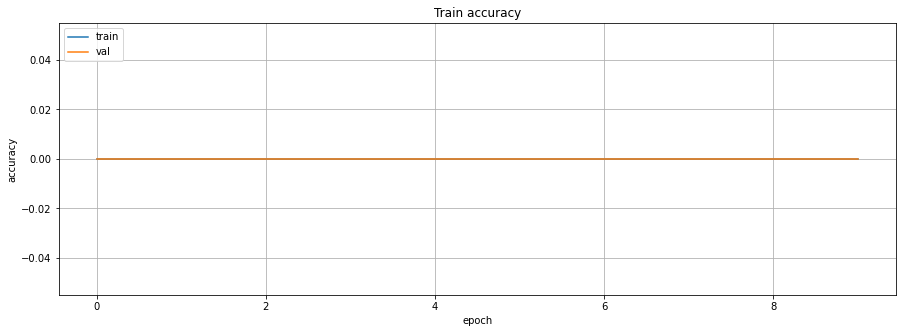

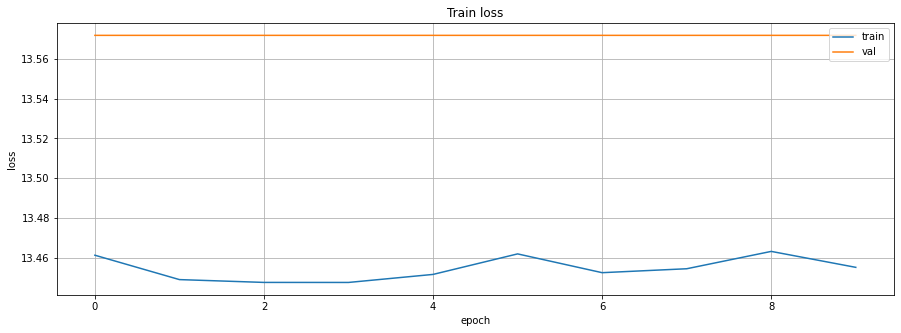

In [20]:
# Summarize history for accuracy
plt.figure(figsize=(15,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

# Summarize history for loss
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid()
plt.show()

# 5.Evaluate the model

In [23]:
# Evaluate the model
results = vgg_extractor.evaluate(test_ds)

3/3 [==============================] - 26s 212ms/step - loss: 13.3670 - acc: 0.0000e+00


In [24]:
print( f"Test results from last model:{vgg_extractor.metrics_names}: {results}\n" )

Test results from last model:['loss', 'acc']: [13.36701774597168, 0.0]



#6.Inference

In [25]:
test_ds_u = test_ds.unbatch()

lst_x = []
lst_y = []
for batch_images, batch_labels in test_ds_u :
  A = tf.keras.applications.vgg16.preprocess_input(batch_images)
  B = batch_labels
  lst_x.append(A)
  lst_y.append(B)

x_test = tf.stack(lst_x)
y_test = tf.stack(lst_y)

In [26]:
x_test.shape

TensorShape([80, 224, 224, 3])

In [27]:
x_test[0].dtype

tf.float32

In [28]:
x = tf.keras.applications.vgg16.preprocess_input(x_test)

In [29]:
# Use the model to predict this image
pred = vgg_extractor.predict(x)  #reshape ก็ได้ เพื่อบอก Batch size

3/3 [==============================] - 0s 43ms/step


In [30]:
pred.shape

(80, 1000)

In [36]:
for j in range(10):
  predictions = tf.keras.applications.mobilenet.decode_predictions(pred, top=5)[j]
  print("Pic", j+1 , "Class: ", class_names[y_test[j]])
  for i, prediction in enumerate(predictions):
    print( f"\tRank {i+1}: {prediction[1],prediction[2]}")

Pic 1 Class:  apple
	Rank 1: ('Band_Aid', 0.33808225)
	Rank 2: ('envelope', 0.12236065)
	Rank 3: ('carton', 0.10680499)
	Rank 4: ('mailbag', 0.039833583)
	Rank 5: ('wallet', 0.03881733)
Pic 2 Class:  huawei
	Rank 1: ('wallet', 0.25158975)
	Rank 2: ('microwave', 0.123779595)
	Rank 3: ('binder', 0.09137395)
	Rank 4: ('mailbag', 0.056398854)
	Rank 5: ('tape_player', 0.055683453)
Pic 3 Class:  apple
	Rank 1: ('wallet', 0.7828528)
	Rank 2: ('mailbag', 0.062287312)
	Rank 3: ('parachute', 0.031603266)
	Rank 4: ('book_jacket', 0.019281434)
	Rank 5: ('purse', 0.015697895)
Pic 4 Class:  oppo
	Rank 1: ('binder', 0.17570657)
	Rank 2: ('whistle', 0.13295814)
	Rank 3: ('pencil_box', 0.07509843)
	Rank 4: ('wall_clock', 0.07445655)
	Rank 5: ('ballpoint', 0.06234298)
Pic 5 Class:  oppo
	Rank 1: ('modem', 0.56080526)
	Rank 2: ('digital_clock', 0.21760704)
	Rank 3: ('cassette_player', 0.03955216)
	Rank 4: ('joystick', 0.030060356)
	Rank 5: ('switch', 0.029685019)
Pic 6 Class:  apple
	Rank 1: ('bib', 0.81

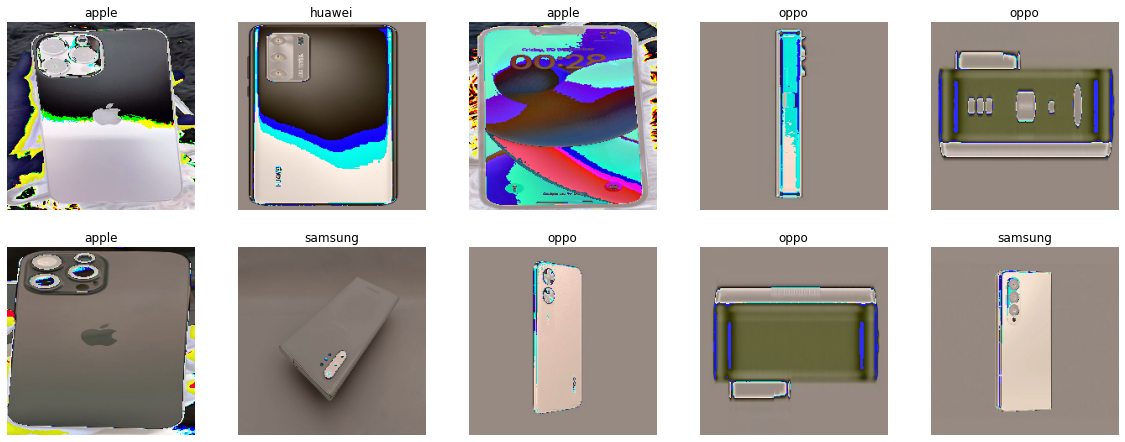

In [32]:
plt.figure(figsize=(20, 20))

for i in range(10):
  ax = plt.subplot(5, 5, i + 1)
  plt.imshow(x_test[i].numpy().astype("uint8"))
  plt.title( class_names[y_test[i]] )
  plt.axis("off")

# 7.Classification 10 vs Input 4

In [33]:
# Retrieve a batch of images from the test set
image_batch,label_batch  = test_ds.as_numpy_iterator().next()
predictions = vgg_extractor.predict_on_batch(image_batch) # Returns predictions for a single batch of samples.


In [34]:
print (type(image_batch),", dtype=",image_batch.dtype,", shape=",image_batch.shape)
print (type(label_batch ),", dtype=",label_batch .dtype,", shape=",label_batch .shape)

<class 'numpy.ndarray'> , dtype= float32 , shape= (32, 224, 224, 3)
<class 'numpy.ndarray'> , dtype= int32 , shape= (32,)


In [35]:
for i in range(10):
  print("No.", i, 'Labels:', class_names[label_batch[i]], 'Predictions:', class_names[np.argmax(predictions[i])])

IndexError: ignored

IndexError: ignored

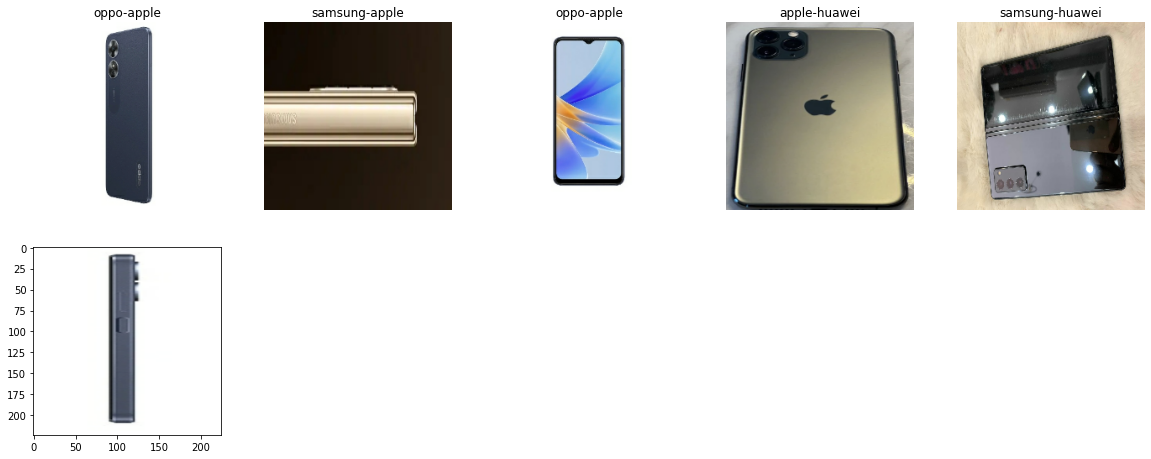

In [37]:
plt.figure(figsize=(20, 20))

for i in range(20):
  ax = plt.subplot(5, 5, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title( class_names[label_batch[i]] + "-" +class_names[np.argmax(predictions[i])] )  # y_test y_pred
  plt.axis("off")

# 8.Download model

In [39]:
!cp bestmodel_epoch01_valloss13.57.hdf5 /content/gdrive/MyDrive